In [5]:
# %matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
import sys
sys.path.insert(0, 'functions/')
from h5_tools import *
from fitting_tools import *
import numpy as np
import h5py as h5
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
import pickle
# from matplotlib.colors import LogNorm

In [7]:
h5dir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/'

# Select run

In [8]:
!ls -l /cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/*50_5*

-rw-rw-r--+ 1 mabi3848 hpc-users 3054376047 Jun 20 00:02 /cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_5_0004.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 2697540517 Jun 20 09:32 /cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_5_0005.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 1223385279 Jun 19 23:57 /cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_5_0006.h5


In [9]:
# fluxes 220K: 4 full beam, 5 45%, 6 22.5%
runname = 'ferritin_conc_gly_50_5'
datasetnumbers = [4,5,6]

In [19]:
Tr = []
for datasetnumber in datasetnumbers:
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
    if os.path.isfile(filename):
        print(filename, "\nFile exists: ", os.path.isfile(filename), "\n")
        info = elog_selected_entries_dict(filename)
        for key in info.keys():
            print("{0:20} {1}".format(key, info[key]))
        Tr.append(info['transmission (%)'])
    else:
        print(filename, "\nFile exists: False")
T = info['Temperature, K']

/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_5_0004.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_5_0004
Temperature, K       220.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 220K, full beam
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_5_0005.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_5_0005
Temperature, K       220.0
transmission (%)     45
Absorbers 80um       1.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 220K, 45% beam
Exposure time (s)    0.0004
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_5_0006.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_5_0006
Temper

In [12]:
Tr

['100', '45', '~22.5']

# Plot g2s

In [13]:
def exponential(x, beta, tau, c):
    return np.abs(beta) * np.exp( -2*x/(np.abs(tau)) )

def exponential_kww(x, beta, tau, c, kww):
    return np.abs(beta) * np.exp( -2*(x/(np.abs(tau)))**kww )

def linear(x, m):
    return m*x
# popt,xc,curve,perr = fit(gaussian, x[fmin:fmax], y[fmin:fmax], p0=[.4,.8,.3])


In [14]:
filename = h5dir + f'{runname}_{datasetnumbers[0]:04d}.h5'
delay = load_data(filename, 'xpcs/g2s/delay')
qv = load_data(filename, 'xpcs/g2s/q')

rep = 0
g2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))

for i,datasetnumber in enumerate(datasetnumbers):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
    g2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s')[rep,:,:]

print(np.shape(g2s))

(3, 12, 80)


### With kww=1

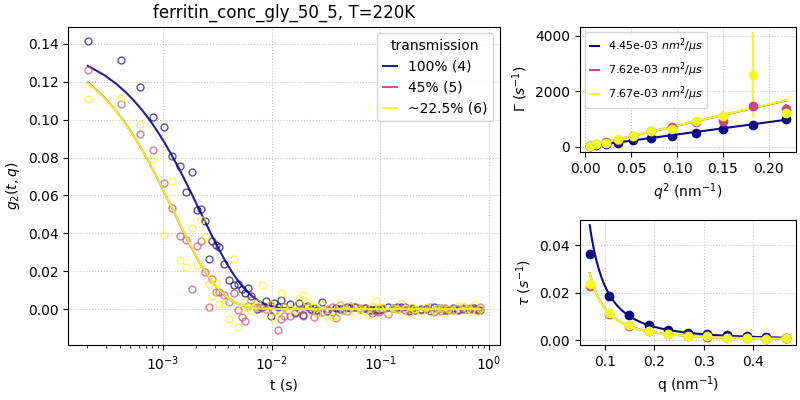

In [27]:
f = plt.figure(figsize=(8,4), constrained_layout=True)
gs = f.add_gridspec(2, 3)
a1 = f.add_subplot(gs[:2, :2])
a3 = f.add_subplot(gs[0, 2])
a4 = f.add_subplot(gs[1, 2])

col = plt.cm.plasma(np.linspace(0,1,len(datasetnumbers)))
# taus, dtaus = [], []
qv_sel = 5
qv_min, qv_max = 1, len(qv)
for i in range(len(datasetnumbers)):
    
#     base = 0
    taus, dtaus = [], []
    for q in range(qv_min, qv_max):
        base = np.average(g2s[i,q,-15:])
        beta_p0 = 0.14
        popt,xc,curve,perr = fit(exponential, delay, g2s[i,q,:]-base, p0=[beta_p0,5e-2,1], bounds=[(beta_p0-1e-3,0,0),(beta_p0+1e-3,np.infty,3)])
        taus.append(popt[1])
        dtaus.append(perr[1])
        
        if q==qv_sel:
            a1.plot(delay, g2s[i,q,:]-base, c=col[i], ls='', marker='o', ms=5, mfc='none', alpha=0.7)
            a1.plot(xc, curve, c=col[i], ls='-', alpha=0.9, label=f'{Tr[i]}% ({datasetnumbers[i]})')
#             a2.errorbar(qv[i], popt[0], perr[0], c=col[i], ls='', marker='o')
            
#         popt,xc,curve,perr = fit(exponential, delay, g2s[i,qq,:]-base, p0=[beta_p0,5e-2,1], bounds=[(beta_p0-1e-3,0,0),(beta_p0+1e-3,np.infty,3)])
#         a1.plot(xc, curve, c=col[i], ls='-', alpha=0.9, label=f'{qv[qq]:.2f}')
#         a2.errorbar(qv[i], popt[0], perr[0], c='r', ls='', marker='o')
#         taus.append(popt[1])
#         dtaus.append(perr[1])

    taus, dtaus = np.asarray(taus), np.asarray(dtaus)
    popt,xc,curve,perr = fit(linear, qv[qv_min:qv_max]**2, 1/taus, sigma=dtaus/(taus**2), p0=[5e3])
    a3.plot(xc, curve, c=col[i], label=f'{popt[0]*1e-6:.2e} ${{nm}}^{{2}}$/${{\mu s}}$')
    a4.plot(np.sqrt(xc), 1/curve, c=col[i], label=f'{popt[0]*1e-6:.2e} ${{nm}}^{{2}}$/${{\mu s}}$')
    a3.errorbar(qv[qv_min:qv_max]**2, 1/taus, dtaus/(taus**2), c=col[i], ls='', marker='o')
    a4.plot(qv[qv_min:qv_max], taus, c=col[i], ls='', marker='o')

a1.legend(title=r'transmission', fontsize=10, bbox_to_anchor=[1,1], handlelength=1)
a1.set_title(f"{runname}, T={T[:-2]}K")
a1.set_xscale('log')
a1.set_xlabel(r't (s)')
a1.set_ylabel(r'$g_2(t,q)$')
a3.set_xlabel(r'$q^2$ (nm$^{-1}$)')
a3.set_ylabel(r'$\Gamma$ ($s^{-1}$)')
a4.set_xlabel(r'q (nm$^{-1}$)')
a4.set_ylabel(r'$\tau$ ($s^{-1}$)')
a1.grid(ls=':', alpha=.7)
a3.grid(ls=':', alpha=.7)
a4.grid(ls=':', alpha=.7)
a3.legend(fontsize=8, handlelength=.8);

### Free kww

In [140]:
mpl.rcParams.update({"axes.grid" : True, "grid.color": "gray", "grid.linestyle":":", "grid.alpha": "0.7"})
f, ((a1,a2),(a3,a4)) = plt.subplots(2,2,figsize=(8,7), constrained_layout=True)

# f = plt.figure(figsize=(8,4), constrained_layout=True)
# gs = f.add_gridspec(2, 3)
# a1 = f.add_subplot(gs[:2, :2])
# a3 = f.add_subplot(gs[0, 2])
# a4 = f.add_subplot(gs[1, 2])

col = plt.cm.plasma(np.linspace(0,1,len(datasetnumbers)))
# taus, dtaus = [], []

beta_p0, dbeta_p0 = 0.14, 1e-1
qv_sel = 5
qv_min, qv_max = 1, len(qv)
for i in range(len(datasetnumbers)):
#     base = np.average(g2s[i,i,-15:])
    base = 0
    for q in range(qv_min, qv_max):
#         beta_p0 = 0.14
        popt,xc,curve,perr = fit(exponential_kww, delay, g2s[i,q,:]-base, p0=[beta_p0,5e-2,1,1.], bounds=[(beta_p0-dbeta_p0,0,0,0),(beta_p0+dbeta_p0,np.infty,3,2)])

        if q==qv_sel:
            a1.plot(delay, g2s[i,q,:]-base, c=col[i], ls='', marker='o', ms=5, mfc='none', alpha=0.7, label=f'{Tr[i]}% ({datasetnumbers[i]})')
            a1.plot(xc, curve, c=col[i], ls='-', alpha=0.9, label=f'{qv[q]:.2f}')
            
            a2.errorbar(qv[i], popt[0], perr[0], c=col[i], ls='', marker='o')
            a4.errorbar(qv[i], popt[3], perr[3], c=col[i], ls='', marker='o')
            taus.append(popt[1])
            dtaus.append(perr[1])
#         popt,xc,curve,perr = fit(exponential, delay, g2s[i,qq,:]-base, p0=[beta_p0,5e-2,1], bounds=[(beta_p0-1e-3,0,0),(beta_p0+1e-3,np.infty,3)])
#         a1.plot(xc, curve, c=col[i], ls='-', alpha=0.9, label=f'{qv[qq]:.2f}')
#         a2.errorbar(qv[i], popt[0], perr[0], c='r', ls='', marker='o')
#         taus.append(popt[1])
#         dtaus.append(perr[1])

    taus, dtaus = np.asarray(taus), np.asarray(dtaus)
    popt,xc,curve,perr = fit(linear, qv[qv_min:qv_max]**2, 1/taus, sigma=dtaus/(taus**2), p0=[5e3])
    a3.plot(xc, curve, c=col[i], label=f'{popt[0]*1e-6:.2e} ${{nm}}^{{2}}$/${{\mu s}}$')
    a3.errorbar( qv[qv_min:qv_max]**2, 1/taus, dtaus/(taus**2),  c=col[i], ls='', marker='o')
    
f.sup_title(f"{runname}, T={T[:-2]}K")
a1.legend(title=r'q (nm$^{-1}$)', fontsize=8, bbox_to_anchor=[1,1], handlelength=.5)
a1.set_xscale('log')
a1.set_xlabel(r't (s)')
a1.set_ylabel(r'$g_2(t,q)$')
a2.set_xlabel(r'q (nm$^{-1}$)')
a2.set_ylabel('contrast')
a3.set_xlabel(r'$q^2$ (nm$^{-1}$)')
a3.set_ylabel(r'$\Gamma$ ($s^{-1}$)')
a4.set_xlabel(r'q (nm$^{-1}$)')
a4.set_ylabel('KWW')

# calcualte something from anita
**I think it's the estimation of the contrast vs q**

In [130]:
# variables
bs         = 11*1e-6    # beam size in m 
d         =  1.5e-3   # sample thickness in m
E         =  9        # Energy in keV
L         =  7   # sample-detector-distance in m
delLamLam =  5e-3     # Delta E over E: pink: 2e-3, in felix paper it is fixed at 5e-3 for some reason
P         =  200e-6    # pixel size in m

def calculate_M_det(E,q,delLamLam,bs,L,P,d):

    theta = calculate_theta(q,E)
    M_rad = calculate_M_rad(q,delLamLam,bs,E)
    M_det = np.sqrt(1+P**4*bs**2/(M_rad**2*(wavelength(E)* L)**4 )*( (bs**2)*np.cos(theta/2)**2+ (d**2)*np.sin(theta/2)**2) )

    return M_det


def calculate_M_rad(q,delLamLam,bs,E):
    theta=calculate_theta(q,E)
    M_rad=np.sqrt(1+(q**2)*(delLamLam**2)/(4*(np.pi)**2)*((bs**2)*(np.cos(theta))**2 + (d**2)*(np.sin(theta))**2 ))
    return M_rad


def speckle_contrast(E,q,delLamLam,bs,L,P,d):
    q=q*1e9
    beta = .5/(calculate_M_rad(q,delLamLam,bs,E)*calculate_M_det(E,q,delLamLam,bs,L,P,d))
    return beta

def wavelength(E):
    lam = 1.24/E*1e-9
    return lam


def calculate_theta(q,E):
    theta=np.arcsin(q/(4*np.pi/wavelength(E)))*2
    return theta